# 3) Stripped-down poker

In this tutorial, we'll create an extensive-form representation of a one-card poker game from [Reiley et al (2008)](#references), a classroom game under the name "stripped-down poker".
This is perhaps the simplest interesting game with imperfect information.

We'll use "stripped-down poker" to demonstrate and explain the following with Gambit:

1. Setting up an extensive-form game with imperfect information using [information sets](#information-sets)
2. [Computing and interpreting Nash equilibria](#computing-and-interpreting-nash-equilibria) and understanding mixed behaviour and mixed strategy profiles
3. [Acceptance criteria for Nash equilibria](#acceptance-criteria-for-nash-equilibria)

In our version of the game, there are two players, **Alice** and **Bob**, and a deck of cards, with equal numbers of **King** and **Queen** cards.

- The game begins with each player putting \$1 in the pot.
    - A card is dealt at random to Alice.
    - Alice observes her card.
    - Bob does not observe the card.
- Alice then chooses either to **Bet** or to **Fold**.
    - If she chooses to Fold, Bob wins the pot and the game ends.
    - If she chooses to Bet, she adds another \$1 to the pot.
- Bob then chooses either to **Call** or **Fold**.
    - If he chooses to Fold, Alice wins the pot and the game ends.
    - If he chooses to Call, he adds another $1 to the pot.
- There is then a showdown, in which Alice reveals her card.
    - If she has a King, then she wins the pot.
    - If she has a Queen, then Bob wins the pot.

In addition to `pygambit`, this tutorial uses the `draw_tree` package, which can be used to draw extensive form games in Python.
If you're running this tutorial on your local machine, you'll need to install the requirements for [draw_tree](https://github.com/gambitproject/draw_tree), which include LaTeX, in order to run the `draw_tree` cells.
Another option for visualising extensive form games is to install the Gambit GUI and use it to load a saved EFG file.

In [1]:
from draw_tree import draw_tree

import pygambit as gbt

Create the game with two players:

In [2]:
g = gbt.Game.new_tree(
    players=["Alice", "Bob"],
    title="Stripped-Down Poker: a simple game of one-card poker from Reiley et al (2008)."
)

In addition to the two named players, Gambit also instantiates a chance player.

In [3]:
print(g.players["Alice"])
print(g.players["Bob"])
print(g.players.chance)

Player(game=Game(title='Stripped-Down Poker: a simple game of one-card poker from Reiley et al (2008).'), label='Alice')
Player(game=Game(title='Stripped-Down Poker: a simple game of one-card poker from Reiley et al (2008).'), label='Bob')
ChancePlayer(game=Game(title='Stripped-Down Poker: a simple game of one-card poker from Reiley et al (2008).'))


Moves belonging to the chance player can be added in the same way as to other players.

At any new move created for the chance player, the action probabilities default to uniform randomization over the actions at the move.

The first step in this game is that Alice is dealt a card which could be a King or Queen, each with probability 1/2.

To simulate this in Gambit, we create a chance player move at the root node of the game:

In [4]:
g.append_move(
    g.root,
    player=g.players.chance,
    actions=["King", "Queen"]  # By default, chance actions have equal probabilities
)

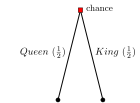

In [5]:
draw_tree(g)

## Information sets

In this game, information structure is important.
Alice knows her card, so the two nodes at which she has the move are part of different **information sets**.

We'll therefore need to append Alice's move separately for each of the root node's children, i.e. the scenarios where she has a King or a Queen.
Let's now add both of these possible moves:

In [6]:
for node in g.root.children:
    g.append_move(
        node,
        player="Alice",
        actions=["Bet", "Fold"]
    )

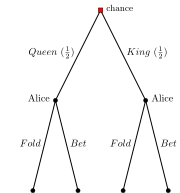

In [7]:
draw_tree(g)

The loop above causes each of the newly-appended moves to be in new information sets, reflecting the fact that Alice's decision depends on the knowledge of which card she holds.

In contrast, Bob does not know Alice’s card, and therefore cannot distinguish between the two nodes at which he has to make his decision:

  - Chance player chooses King, then Alice Bets: `g.root.children["King"].children["Bet"]`
  - Chance player chooses Queen, then Alice Bets: `g.root.children["Queen"].children["Bet"]`

In other words, Bob's decision when Alice Bets with a Queen should be part of the same information set as Bob's decision when Alice Bets with a King.

To set this scenario up in Gambit, we'll need to add both possible moves as part of the same information set (represented in Gambit as an `Infoset`).
This can be done by passing a list of nodes to the `append_move` method:

In [8]:
g.append_move(
    [g.root.children["King"].children["Bet"], g.root.children["Queen"].children["Bet"]],
    player="Bob",
    actions=["Call", "Fold"]
)

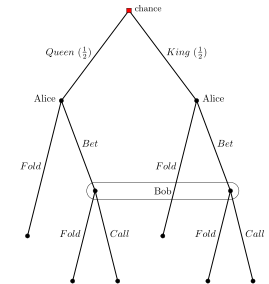

In [9]:
draw_tree(g)

In game theory terms, this creates "imperfect information".
Bob cannot distinguish between these two nodes in the game tree, so he must use the same same probabilities for Call vs. Fold in both situations.

This is crucial in games where players must make decisions without full knowledge of the state of the game.

Let's now set up the four possible payoff outcomes for the game. We'll label them according to player 1 (Alice):

In [10]:
win_big = g.add_outcome([2, -2], label="Win Big")
win = g.add_outcome([1, -1], label="Win")
lose_big = g.add_outcome([-2, 2], label="Lose Big")
lose = g.add_outcome([-1, 1], label="Lose")

Finally, we should assign an outcome to each of the terminal nodes in the game tree:

In [11]:
# Alice folds, Bob wins small
g.set_outcome(g.root.children["King"].children["Fold"], lose)
g.set_outcome(g.root.children["Queen"].children["Fold"], lose)

# Bob sees Alice Bet and calls, correctly believing she is bluffing, Bob wins big
g.set_outcome(g.root.children["Queen"].children["Bet"].children["Call"], lose_big)

# Bob sees Alice Bet and calls, incorrectly believing she is bluffing, Alice wins big
g.set_outcome(g.root.children["King"].children["Bet"].children["Call"], win_big)

# Bob does not call Alice's Bet, Alice wins small
g.set_outcome(g.root.children["King"].children["Bet"].children["Fold"], win)
g.set_outcome(g.root.children["Queen"].children["Bet"].children["Fold"], win)

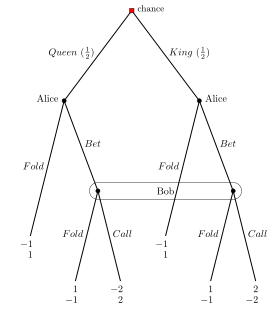

In [12]:
draw_tree(g)

## Computing and interpreting Nash equilibria
<a id="cne"></a>

Since our one-card poker game has two players, we can use the `lcp_solve` algorithm in Gambit to compute a Nash equilibrium:

In [13]:
result = gbt.nash.lcp_solve(g)
result

NashComputationResult(method='lcp', rational=True, use_strategic=False, equilibria=[[[[Rational(1, 1), Rational(0, 1)], [Rational(1, 3), Rational(2, 3)]], [[Rational(2, 3), Rational(1, 3)]]]], parameters={'stop_after': 0, 'max_depth': 0})

The result of the calculation is returned as a `NashComputationResult` object.

The set of equilibria found is reported in `NashComputationResult.equilibria`; in this case, this is a list of `MixedBehaviorProfile`'s.

For one-card poker, we expect to find a single equilibrium (one `MixedBehaviorProfile`):

In [14]:
print("Number of equilibria found:", len(result.equilibria))
eqm = result.equilibria[0]

Number of equilibria found: 1


If we inspect the object type, we can see it's a `MixedBehaviorProfileRational` which is a subclass of `MixedBehaviorProfile` that uses rational numbers for probabilities:

In [15]:
type(eqm)

pygambit.gambit.MixedBehaviorProfileRational

A mixed behavior profile specifies, for each information set, the probability distribution over actions at that information set.

Indexing a mixed behaviour profile by a player gives a `MixedBehavior`, which specifies probability distributions at each of the player's information sets:

In [16]:
type(eqm["Alice"])

pygambit.gambit.MixedBehavior

In [17]:
eqm["Alice"]

[[Rational(1, 1), Rational(0, 1)], [Rational(1, 3), Rational(2, 3)]]

In this case, at Alice's first information set, the one at which she has the King, she always Bets.

At her second information set, where she has the Queen, she sometimes bluffs, raising with probability one-third.

The probability distribution at an information set is represented by a `MixedAction`.

`MixedBehavior.mixed_actions` iterates over these for the player:

In [18]:
for infoset, mixed_action in eqm["Alice"].mixed_actions():
    print(
        f"At information set {infoset.number}, "
        f"Alice plays Bet with probability: {mixed_action['Bet']}"
        f" and Fold with probability: {mixed_action['Fold']}"
    )

At information set 0, Alice plays Bet with probability: 1 and Fold with probability: 0
At information set 1, Alice plays Bet with probability: 1/3 and Fold with probability: 2/3


We can alternatively iterate through each of a player's actions like so:

In [19]:
for action in g.players["Alice"].actions:
    print(
        f"At information set {action.infoset.number}, "
        f"Alice plays {action.label} with probability: {eqm[action]}"
    )

At information set 0, Alice plays Bet with probability: 1
At information set 0, Alice plays Fold with probability: 0
At information set 1, Alice plays Bet with probability: 1/3
At information set 1, Alice plays Fold with probability: 2/3


Now let's look at Bob’s strategy:

In [20]:
eqm["Bob"]

[[Rational(2, 3), Rational(1, 3)]]

Bob Calls Alice’s Bet two-thirds of the time.
The label “Bet” is used in more than one information set for Alice, so in the above we had to specify information sets when indexing.

When there is no ambiguity, we can specify action labels directly.
So for example, because Bob has only one action named “Call” in the game, we can extract the probability that Bob plays “Call” by:

In [21]:
eqm["Bob"]["Call"]

Rational(2, 3)

Moreover, this is the only action with that label in the game, so we can index the profile directly using the action label without any ambiguity:

In [22]:
eqm["Call"]

Rational(2, 3)

Because this is an equilibrium, Bob is indifferent between the two actions at his information set, meaning he has no reason to prefer one action over the other, in expectation, given Alice's expected strategy.

`MixedBehaviorProfile.action_value` returns the expected payoff of taking an action, conditional on reaching that action's information set:

In [23]:
# Remember that Bob has a single information set
for action in g.players["Bob"].infosets[0].actions:
    print(
        f"When Bob plays {action.label} his expected payoff is {eqm.action_value(action)}"
    )

When Bob plays Call his expected payoff is -1
When Bob plays Fold his expected payoff is -1


Bob's indifference between his actions arises because of his beliefs given Alice's strategy.

`MixedBehaviorProfile.belief` returns the probability of reaching a node, conditional on its information set being reached.

Recall that the two nodes in Bob's only information set are `g.root.children["King"].children["Bet"]` and `g.root.children["Queen"].children["Bet"]`):

In [24]:
for node in g.players["Bob"].infosets[0].members:
    print(
        f"Bob's belief in reaching the {node.parent.prior_action.label} -> "
        f"{node.prior_action.label} node is: {eqm.belief(node)}"
    )

Bob's belief in reaching the King -> Bet node is: 3/4
Bob's belief in reaching the Queen -> Bet node is: 1/4


Bob believes that, conditional on Alice raising, there's a 3/4 chance that she has the King; therefore, the expected payoff to Calling is in fact -1 as computed.

`MixedBehaviorProfile.infoset_prob` returns the probability that an information set is reached:

In [25]:
eqm.infoset_prob(g.players["Bob"].infosets[0])

Rational(2, 3)

The corresponding probability that a node is reached in the play of the game is given by `MixedBehaviorProfile.realiz_prob`, and the expected payoff to a player conditional on reaching a node is given by `MixedBehaviorProfile.node_value`:

In [26]:
for node in g.players["Bob"].infosets[0].members:
    print(
        f"The probability that the node {node.parent.prior_action.label} -> "
        f"{node.prior_action.label} is reached is: {eqm.realiz_prob(node)}. ",
        f"Bob's expected payoff conditional on reaching this node is {eqm.node_value('Bob', node)}"
    )

The probability that the node King -> Bet is reached is: 1/2.  Bob's expected payoff conditional on reaching this node is -5/3
The probability that the node Queen -> Bet is reached is: 1/6.  Bob's expected payoff conditional on reaching this node is 1


The overall expected payoff to a player given the behavior profile is returned by `MixedBehaviorProfile.payoff`:

In [27]:
eqm.payoff("Alice")

Rational(1, 3)

In [28]:
eqm.payoff("Bob")

Rational(-1, 3)

The equilibrium computed expresses probabilities in rational numbers.

Because the numerical data of games in Gambit [are represented exactly](#representation-of-numerical-data-of-a-game), methods which are specialized to two-player games, `lp_solve`, `lcp_solve`, and `enummixed_solve`, can report exact probabilities for equilibrium strategy profiles.

This is enabled by default for these methods.

When a game has an extensive representation, equilibrium finding methods default to computing on that representation.
It is also possible to compute using the strategic representation.
`pygambit` transparently computes the reduced strategic form representation of an extensive game:

In [29]:
[s.label for s in g.players["Alice"].strategies]

['11', '12', '21', '22']

In the strategic form of this game, Alice has four strategies.

The generated strategy labels list the action numbers taken at each information set.
For example, label '11' refers to the strategy gets dealt the King, then Bets.

We can therefore apply a method which operates on a strategic game to any game with an extensive representation.

In [30]:
gnm_result = gbt.nash.gnm_solve(g)
gnm_result

NashComputationResult(method='gnm', rational=False, use_strategic=True, equilibria=[[[0.33333333333866677, 0.6666666666613335, 0.0, 0.0], [0.6666666666559997, 0.3333333333440004]]], parameters={'perturbation': [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0]], 'end_lambda': -10.0, 'steps': 100, 'local_newton_interval': 3, 'local_newton_maxits': 10})

`gnm_solve` can be applied to any game with any number of players, and uses a path-following process in floating-point arithmetic, so it returns profiles with probabilities expressed as floating-point numbers.

This method operates on the strategic representation of the game, so the returned results are of type `MixedStrategyProfile` (specifically `MixedStrategyProfileDouble`):

In [31]:
gnm_eqm = gnm_result.equilibria[0]
type(gnm_eqm)

pygambit.gambit.MixedStrategyProfileDouble

Indexing a `MixedStrategyProfile` by a player gives the probability distribution over that player's strategies only.

The expected payoff to a strategy is provided by `MixedStrategyProfile.strategy_value` and the overall expected payoff to a player is returned by `MixedStrategyProfile.payoff`:

In [32]:
for player in g.players:
    print(
        f"{player.label}'s expected payoffs playing:"
    )
    for strategy in player.strategies:
        print(
            f"Strategy {strategy.label}: {gnm_eqm.strategy_value(strategy):.4f}"
        )
    print(
        f"{player.label}'s overall expected payoff: {gnm_eqm.payoff(player):.4f}"
    )
    print()

Alice's expected payoffs playing:
Strategy 11: 0.3333
Strategy 12: 0.3333
Strategy 21: -1.0000
Strategy 22: -1.0000
Alice's overall expected payoff: 0.3333

Bob's expected payoffs playing:
Strategy 1: -0.3333
Strategy 2: -0.3333
Bob's overall expected payoff: -0.3333



When a game has an extensive representation, we can convert freely between a mixed strategy profile and the corresponding mixed behaviour profile representation of the same strategies using `MixedStrategyProfile.as_behavior` and `MixedBehaviorProfile.as_strategy`.

- A mixed **strategy** profile maps each strategy in a game to the corresponding probability with which that strategy is played.
- A mixed **behaviour** profile maps each action at each information set in a game to the corresponding probability with which the action is played, conditional on that information set being reached.

Let's convert the equilibrium we found using `gnm_solve` to a mixed behaviour profile and iterate through the players actions to show their expected payoffs, comparing as we go with the payoffs found by `lcp_solve`:

In [33]:
for player in g.players:
    print(
        f"{player.label}'s expected payoffs:"
    )
    for action in player.actions:
        print(
            f"At information set {action.infoset.number}, "
            f"when playing {action.label} - "
            f"gnm: {gnm_eqm.as_behavior().action_value(action):.4f}"
            f", lcp: {eqm.action_value(action):.4f}"
        )
    print()

Alice's expected payoffs:
At information set 0, when playing Bet - gnm: 1.6667, lcp: 1.6667
At information set 0, when playing Fold - gnm: -1.0000, lcp: -1.0000
At information set 1, when playing Bet - gnm: -1.0000, lcp: -1.0000
At information set 1, when playing Fold - gnm: -1.0000, lcp: -1.0000

Bob's expected payoffs:
At information set 0, when playing Call - gnm: -1.0000, lcp: -1.0000
At information set 0, when playing Fold - gnm: -1.0000, lcp: -1.0000



Acceptance criteria for Nash equilibria
---------------------------------------

Some methods for computing Nash equilibria operate using floating-point arithmetic and/or generate candidate equilibrium profiles using methods which involve some form of successive approximations.
The outputs of these methods therefore are in general $\varepsilon$-equilibria, for some positive $\varepsilon$.

$\varepsilon$-equilibria (from [Wikipedia](https://en.wikipedia.org/wiki/Epsilon-equilibrium)):

> In game theory, an epsilon-equilibrium, or near-Nash equilibrium, is a strategy profile that approximately satisfies the condition of Nash equilibrium. In a Nash equilibrium, no player has an incentive to change his behavior. In an approximate Nash equilibrium, this requirement is weakened to allow the possibility that a player may have a small incentive to do something different.

> Given a game and a real non-negative parameter $\varepsilon$, a strategy profile is said to be an $\varepsilon$-equilibrium if it is not possible for any player to gain more than $\varepsilon$ in expected payoff by unilaterally deviating from his strategy. Every Nash Equilibrium is an $\varepsilon$-equilibrium where $\varepsilon = 0$.


To provide a uniform interface across methods, where relevant Gambit provides a parameter
`maxregret`, which specifies the acceptance criterion for labeling the output of the
algorithm as an equilibrium.
This parameter is interpreted *proportionally* to the range of payoffs in the game.
Any profile returned as an equilibrium is guaranteed to be an $\varepsilon$-equilibrium, for $\varepsilon$ no more than `maxregret`
times the difference of the game's maximum and minimum payoffs.

As an example, consider solving our one-card poker game using `logit_solve`.  The range of the payoffs in this game is 4 (from +2 to -2):


In [34]:
g.max_payoff, g.min_payoff

(Rational(2, 1), Rational(-2, 1))

`logit_solve` is a globally-convergent method, in that it computes a sequence of profiles which is guaranteed to have a subsequence that converges to a
Nash equilibrium.

The default value of `maxregret` for this method is set at $10^{-8}$:

In [35]:
logit_solve_result = gbt.nash.logit_solve(g, maxregret=1e-8)
len(logit_solve_result.equilibria)

1

In [36]:
ls_eqm = logit_solve_result.equilibria[0]
ls_eqm.max_regret()

3.987411578698641e-08

The value of `MixedBehaviorProfile.max_regret` of the computed profile exceeds $10^{-8}$ measured in payoffs of the game.
However, when considered relative to the scale of the game's payoffs, we see it is less than $10^{-8}$ of the payoff range, as requested:

In [37]:
ls_eqm.max_regret() / (g.max_payoff - g.min_payoff)

9.968528946746602e-09

In general, for globally-convergent methods especially, there is a tradeoff between precision and running time.

We could instead ask only for an $\varepsilon$-equilibrium with a (scaled) $\varepsilon$ of no more than $10^{-4}$:

In [38]:
gbt.nash.logit_solve(g, maxregret=1e-4).equilibria[0].max_regret() / (g.max_payoff - g.min_payoff)

9.395259956013202e-05

The tradeoff comes from some methods being slow to converge on some games, making it useful instead to get a more coarse approximation to an equilibrium (higher `maxregret` value) which is faster to calculate:

In [39]:
%%time
gbt.nash.logit_solve(g, maxregret=1e-4)

CPU times: user 8.72 ms, sys: 143 μs, total: 8.86 ms
Wall time: 8.85 ms


NashComputationResult(method='logit', rational=False, use_strategic=False, equilibria=[[[[1.0, 0.0], [0.3338351656285655, 0.666164834417892]], [[0.6670407651644307, 0.3329592348608147]]]], parameters={'first_step': 0.03, 'max_accel': 1.1})

In [40]:
%%time
gbt.nash.logit_solve(g, maxregret=1e-8)

CPU times: user 16.7 ms, sys: 234 μs, total: 17 ms
Wall time: 17 ms


NashComputationResult(method='logit', rational=False, use_strategic=False, equilibria=[[[[1.0, 0.0], [0.33333338649882943, 0.6666666135011706]], [[0.6666667065407631, 0.3333332934592369]]]], parameters={'first_step': 0.03, 'max_accel': 1.1})

The convention of expressing `maxregret` scaled by the game's payoffs standardises the behavior of methods across games.

For example, consider solving the poker game instead using `liap_solve()`:

In [41]:
(
    gbt.nash.liap_solve(g.mixed_behavior_profile(), maxregret=1.0e-4)
    .equilibria[0].max_regret() / (g.max_payoff - g.min_payoff)
)

5.509533871672634e-05

If, instead, we double all payoffs, the output of the method is unchanged:

In [42]:
for outcome in g.outcomes:
    outcome["Alice"] = outcome["Alice"] * 2
    outcome["Bob"] = outcome["Bob"] * 2

(
    gbt.nash.liap_solve(g.mixed_behavior_profile(), maxregret=1.0e-4)
    .equilibria[0].max_regret() / (g.max_payoff - g.min_payoff)
)

5.509533871672634e-05

## Representation of numerical data of a game

Payoffs to players and probabilities of actions at chance information sets are specified as numbers.
Gambit represents the numerical values in a game in exact precision, using either decimal or rational representations.

To illustrate, consider a trivial game which just has one move for the chance player:

In [43]:
small_game = gbt.Game.new_tree()
small_game.append_move(small_game.root, small_game.players.chance, ["a", "b", "c"])
[act.prob for act in small_game.root.infoset.actions]

[Rational(1, 3), Rational(1, 3), Rational(1, 3)]

The default when creating a new move for chance is that all actions are chosen with equal probability.
These probabilities are represented as rational numbers, using `pygambit`'s `Rational` class, which is derived from Python's `fractions.Fraction`.

Numerical data can be set as rational numbers. Here we update the chance action probabilities with `Rational` numbers:

In [44]:
small_game.set_chance_probs(
    small_game.root.infoset,
    [gbt.Rational(1, 4), gbt.Rational(1, 2), gbt.Rational(1, 4)]
)
[act.prob for act in small_game.root.infoset.actions]

[Rational(1, 4), Rational(1, 2), Rational(1, 4)]

Numerical data can also be explicitly specified as decimal numbers:

In [45]:
small_game.set_chance_probs(
    small_game.root.infoset,
    [gbt.Decimal(".25"), gbt.Decimal(".50"), gbt.Decimal(".25")]
)
[act.prob for act in small_game.root.infoset.actions]

[Decimal('0.25'), Decimal('0.50'), Decimal('0.25')]

Although the two representations above are mathematically equivalent, `pygambit` remembers the format in which the values were specified.

Expressing rational or decimal numbers as above is verbose and tedious.
`pygambit` offers a more concise way to express numerical data in games: when setting numerical game data, `pygambit` will attempt to convert text strings to their rational or decimal representation.
The above can therefore be written more compactly using string representations:

In [46]:
small_game.set_chance_probs(small_game.root.infoset, ["1/4", "1/2", "1/4"])
[act.prob for act in small_game.root.infoset.actions]

[Rational(1, 4), Rational(1, 2), Rational(1, 4)]

In [47]:
small_game.set_chance_probs(small_game.root.infoset, [".25", ".50", ".25"])
[act.prob for act in small_game.root.infoset.actions]

[Decimal('0.25'), Decimal('0.50'), Decimal('0.25')]

As a further convenience, `pygambit` will accept Python `int` and `float` values.
`int` values are always interpreted as `Rational` values.

`pygambit` attempts to render `float` values in an appropriate `Decimal` equivalent.
In the majority of cases, this creates no problems.
For example:

In [48]:
small_game.set_chance_probs(small_game.root.infoset, [.25, .50, .25])
[act.prob for act in small_game.root.infoset.actions]

[Decimal('0.25'), Decimal('0.5'), Decimal('0.25')]

However, rounding can cause difficulties when attempting to use `float` values to represent values which do not have an exact decimal representation:

In [49]:
try:
    small_game.set_chance_probs(small_game.root.infoset, [1/3, 1/3, 1/3])
except ValueError as e:
    print("ValueError:", e)


ValueError: set_chance_probs(): must specify non-negative probabilities that sum to one


This behavior can be slightly surprising, especially in light of the fact that
in Python:

In [50]:
1/3 + 1/3 + 1/3

1.0

In checking whether these probabilities sum to one, `pygambit` first converts each of the probabilities to a `Decimal` representation, via the following method:

In [51]:
gbt.Decimal(str(1/3))

Decimal('0.3333333333333333')

...and the sum-to-one check then fails because:

In [52]:
gbt.Decimal(str(1/3)) + gbt.Decimal(str(1/3)) + gbt.Decimal(str(1/3))

Decimal('0.9999999999999999')

Setting payoffs for players also follows the same rules.
Representing probabilities and payoffs exactly is essential, because `pygambit` offers (in particular for two-player games) the possibility of computation of equilibria exactly, because the Nash equilibria of any two-player game with rational payoffs and chance probabilities can be expressed exactly in terms of rational numbers.

It is therefore advisable always to specify the numerical data of games either in terms of `Decimal` or `Rational` values, or their string equivalents.
It is safe to use `int` values, but `float` values should be used with some care to ensure the values are recorded as intended.

#### References

Reiley, David H., Michael B. Urbancic and Mark Walker. (2008) "Stripped-down poker: A classroom game with signaling and bluffing." *The Journal of Economic Education* 39(4): 323-341.